## Introduction
In this notebook, techniques for tracing a model to identify model its structure and extract parameters for each node, are experimented with.

## Notes and observations

### Initial observations after running this notebook
* Of the tools evaluated, only `torch.fx` is able to infer the model structure when the model is broken
* `torch.fx` does not provide information about activation size, number of parameters or FLOPS. 
  - It seems like this would at least require knowledge of the size of the model inputs, which `torch.fx` does not require
* One idea is to use `torch.fx` to identify the nodes and connections, followed by our own forward pass with hooks inside a `try` statement with
  - For as long as the forward pass succeeds, activation sizes, number of parameters and FLOPS will be available
  - For modules downstream of a failure, these values won't be reported
  - One challenge will be to link the node from our own forward pass to the node identified by `torch.fx`


### Observations after stepping through `torch.fx`
* `Node.name` is unique within a model
* `Node.input_nodes` and `Node.users` specify which nodes are used by the current node and which nodes use it
  - These are read-only properties and can be used to walk the `Graph` as an acyclic graph
  - More information [here](https://github.com/pytorch/pytorch/blob/main/torch/fx/README.md#the-fx-ir-container)
* During `call_module` in `_symbolic_trace.py`, the object reference to the `nn.Module` is not stored
  - The `Node.target` field however contains a fully qualified name from which the `nn.Module` counterparts can be resolved
  - See `Interpreter.fetch_attr` [here](../.venv/lib/python3.10/site-packages/torch/fx/interpreter.py) on how to do this
  - Additionally, the interpreter pattern can be used to extract further information from the nodes
* Nodes in the traced graph can be executed using [the interpreter pattern](https://pytorch.org/docs/stable/fx.html#the-interpreter-pattern)
  - See also the [Interpreter class](https://pytorch.org/docs/stable/fx.html#torch.fx.Interpreter)
  - See also the [Shape propagation example](https://github.com/pytorch/pytorch/blob/main/torch/fx/passes/shape_prop.py)
* Dynamic control flow and non-torch functions are not supported
  - See [Limitations](https://pytorch.org/docs/stable/fx.html#limitations-of-symbolic-tracing)
  - The documentation recommends `torch.compile()` to create multiple graphs for dynamic control flow (see [here](https://github.com/pytorch/pytorch/blob/main/torch/fx/README.md#torchdynamo))
  - Another interesting tutorial is available [here](https://colab.research.google.com/drive/1Zh-Uo3TcTH8yYJF-LLo5rjlHVMtqvMdf)
  - This adds another layer of complexity for further processing and long term support as well as working for broken models may require substantial effort
  - For now, we'll just list the limitations of `torch.fx` as limitations of our tool as well

### Some useful documentation links
* torch.fx [doc page](https://pytorch.org/docs/stable/fx.html)
  - [Primer on graphs](https://pytorch.org/docs/stable/fx.html#a-quick-primer-on-graphs)
  - [Interpreter pattern explanation](https://pytorch.org/docs/stable/fx.html#the-interpreter-pattern)
  - [Interpreter API reference](https://pytorch.org/docs/stable/fx.html#torch.fx.Interpreter)
  - > Tip: On my browser, the API part of the tree on the right does not expand on clicking, but do so on clicking and reloading the page
* torch.fx [readme.md](https://github.com/pytorch/pytorch/blob/main/torch/fx/README.md)
* Examples
  - [Shape propagation](https://pytorch.org/docs/stable/fx.html#examples-of-the-interpreter-pattern) without Interpreter class
  - [shape_prop.py](https://github.com/pytorch/pytorch/blob/main/torch/fx/passes/shape_prop.py) on GitHub
  - [shape_prop.py](../.venv/lib/python3.10/site-packages/torch/fx/passes/shape_prop.py) in editor
  - [Miscellaneous custom tracing examples](https://github.com/pytorch/examples/blob/main/fx/module_tracer.py)
  - [Performance profiler](https://github.com/pytorch/tutorials/pull/1319)

### Tracing strategy
* Start with a symbolic trace using `torch.fx`
  - This retrieves the graph structure and preliminary node names
  - This does not require a working forward pass
  - The output is an `fx.GraphModule`, which contains an `fx.Graph`, which contains multiple `fx.Node` objects
* Next, attempt a forward pass via a custom `fx.Interpreter`
  - In `Interpreter.run_node`, retrieve the shape of each node's activations 
  - In `Interpreter.call_module`, use `profile_macs` from `torchprofiler` to determine the FLOPS
  - Place this inside a `try...catch` in case the forward pass fails
  - Place the FLOPS estimate inside a separate `try...catch` in case issues arise with a new version
    - Consider using a naieve FLOPS estimate as fallback
* Finally, iterate through all nodes in the graph without passing data
  - Retrieve `nn.Module` objects using `Interpreter.fetch_attr(node.target)`
  - Retrieve the node type (e.g. `Conv2D`) and number of parameters from the `nn.Module`

## Imports

In [1]:
import sys
import os
workspace_path = os.path.abspath(os.path.join(os.path.abspath(''), '..'))
sys.path.append(workspace_path)

In [2]:
import torch
from torch import nn, fx, Tensor
import torch.nn.functional as F
import torchvision
import timm

import torchinfo
import torchview
from torchprofile import profile_macs

from miniai.init import clean_mem
from miniai.resnet import ResBlock, act_gr, conv

## Models

### Hand-written CNN (for MNIST)
* Found [here](https://github.com/pytorch/examples/blob/main/mnist/main.py)
* Modified for experimental purposes, e.g. breaking the forward pass

In [3]:
class MnistCnn(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.dropout1 = nn.Dropout(0.25)
        self.dropout2 = nn.Dropout(0.5)
        self.fc1 = nn.Linear(9216, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout2(x)
        x = self.fc2(x)
        output = F.log_softmax(x, dim=1)
        return output

def get_model_cnn_mnist():
    return MnistCnn()

def get_model_cnn_mnist_broken():
    model = MnistCnn()
    model.fc1 = nn.Linear(9216, 120)
    return model

### ResNet18 (from TorchVision)

In [4]:
def get_model_tv_resnet18():
    return torchvision.models.resnet.resnet18()

### ResNet18 (from timm)

In [5]:
def get_model_timm_resnet18():
    return timm.create_model('resnet18', in_chans=3, num_classes=10)

### ResNet (from miniai)

In [6]:
def get_model_miniai_resnet(act=nn.ReLU, nfs=(16,32,64,128,256), norm=nn.BatchNorm2d):
    class GlobalAvgPool(nn.Module):
        def forward(self, x:Tensor): return x.mean((-2,-1))
    layers = [conv(1, 16, ks=5, stride=1, act=act, norm=norm)]
    layers += [ResBlock(nfs[i], nfs[i+1], act=act, norm=norm, stride=2) for i in range(len(nfs)-1)]
    layers += [GlobalAvgPool(), nn.Linear(256, 10, bias=False), nn.BatchNorm1d(10)]
    return nn.Sequential(*layers)

### Autoencoder (from miniai)

In [7]:
def get_model_miniai_autoenc(act=act_gr, nfs=(32,64,128,256,512), norm=nn.BatchNorm2d, drop=0.1):
    def up_block(ni, nf, ks=3, act=act_gr, norm=None):
        return nn.Sequential(nn.UpsamplingNearest2d(scale_factor=2),
                            ResBlock(ni, nf, ks=ks, act=act, norm=norm))
    layers = [ResBlock(3, nfs[0], ks=5, stride=1, act=act, norm=norm)]
    layers += [ResBlock(nfs[i], nfs[i+1], act=act, norm=norm, stride=2) for i in range(len(nfs)-1)]
    layers += [up_block(nfs[i], nfs[i-1], act=act, norm=norm) for i in range(len(nfs)-1,0,-1)]
    layers += [ResBlock(nfs[0], 3, act=nn.Identity, norm=norm)]
    return nn.Sequential(*layers)

### UNet (from miniai)

In [8]:
def up_block(ni, nf, ks=3, act=act_gr, norm=None):
    return nn.Sequential(nn.UpsamplingNearest2d(scale_factor=2),
                        ResBlock(ni, nf, ks=ks, act=act, norm=norm))

class TinyUnet(nn.Module):
    def __init__(self, act=act_gr, nfs=(32,64,128,256,512), norm=nn.BatchNorm2d):
        super().__init__()
        self.start = ResBlock(3, nfs[0], stride=1, act=act, norm=norm)
        self.dn = nn.ModuleList([ResBlock(nfs[i], nfs[i+1], act=act, norm=norm, stride=2)
                                 for i in range(len(nfs)-1)])
        self.up = nn.ModuleList([up_block(nfs[i], nfs[i-1], act=act, norm=norm)
                                 for i in range(len(nfs)-1,0,-1)])
        self.up += [ResBlock(nfs[0], 3, act=act, norm=norm)]
        self.end = ResBlock(3, 3, act=nn.Identity, norm=norm)

    def forward(self, x):
        layers = []
        layers.append(x)
        x = self.start(x)
        for l in self.dn:
            layers.append(x)
            x = l(x)
        n = len(layers)
        for i,l in enumerate(self.up):
            if i!=0: x += layers[n-i]
            x = l(x)
        return self.end(x+layers[0])
    
def get_model_miniai_unet():
    return TinyUnet()

### Model preparation helpers

In [9]:
def get_model_and_input_size(name, device):
    match name:
        case 'cnn_mnist':
            return get_model_cnn_mnist().to(device), (16,1,28,28)
        case 'cnn_mnist_broken':
            return get_model_cnn_mnist_broken().to(device), (16,1,28,28)
        case 'tv_resnet18':
            return get_model_tv_resnet18().to(device), (16,3,160,160)
        case 'timm_resnet18':
            return get_model_timm_resnet18().to(device), (16,3,160,160)
        case 'miniai_resnet':
            return get_model_miniai_resnet().to(device), (16,1,28,28)
        case 'miniai_autoenc':
            return get_model_miniai_autoenc().to(device), (16,3,160,160)
        case 'miniai_unet':
            return get_model_miniai_unet().to(device), (16,3,160,160)
        case _:
            return None
        
def get_models_and_input_tensors(model_names, device):
    """
    This function returns 3 lists:
    * A list of `nn.Module` models
    * A list of tuples: the input sizes for each model
    * A list of tensors that can be passed to each model
    """
    clean_mem()
    models, input_sizes = zip(*[get_model_and_input_size(name, device) for name in model_names])
    models, input_sizes = list(models), list(input_sizes)
    inputs = [torch.randn(input_size).to(device) for input_size in input_sizes]
    return models, input_sizes, inputs

def remove_all_hooks(model:nn.Module):
    # Iterate all submodules of the model
    for module in model.modules():
        # Clear forward hooks
        if hasattr(module, '_forward_hooks'):
            module._forward_hooks.clear()

        # Clear backward hooks
        if hasattr(module, '_backward_hooks'):
            module._backward_hooks.clear()

        # Clear pre-forward hooks if any (less common)
        if hasattr(module, '_forward_pre_hooks'):
            module._forward_pre_hooks.clear()


In [19]:
device = 'cpu'  # ['cpu','cuda']
model_names = ['cnn_mnist', 'cnn_mnist_broken', 'tv_resnet18', 'timm_resnet18', 'miniai_resnet', 'miniai_autoenc', 'miniai_unet']
models, input_sizes, inputs = get_models_and_input_tensors(model_names, device)

## Benchmark tools

### torchview

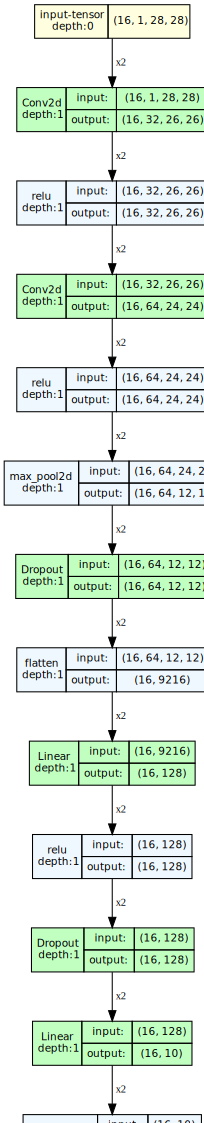

In [11]:
graph = torchview.draw_graph(models[0], input_size=input_sizes[0])
graph.fill_visual_graph()
graph.visual_graph

In [12]:
# Try the broken model
graph = torchview.draw_graph(models[1], input_size=input_sizes[1])
graph.fill_visual_graph()
graph.visual_graph

RuntimeError: Failed to run torchgraph see error message

### torchinfo

In [13]:
torchinfo.summary(models[0], input_size=input_sizes[0], verbose=1, depth=8, 
                  col_names=["output_size","num_params","mult_adds","input_size","kernel_size"]);

Layer (type:depth-idx)                   Output Shape              Param #                   Mult-Adds                 Input Shape               Kernel Shape
MnistCnn                                 [16, 10]                  --                        --                        [16, 1, 28, 28]           --
├─Conv2d: 1-1                            [16, 32, 26, 26]          320                       3,461,120                 [16, 1, 28, 28]           [3, 3]
├─Conv2d: 1-2                            [16, 64, 24, 24]          18,496                    170,459,136               [16, 32, 26, 26]          [3, 3]
├─Dropout: 1-3                           [16, 64, 12, 12]          --                        --                        [16, 64, 12, 12]          --
├─Linear: 1-4                            [16, 128]                 1,179,776                 18,876,416                [16, 9216]                --
├─Dropout: 1-5                           [16, 128]                 --                        -

In [14]:
# Try the broken model
torchinfo.summary(models[1], input_size=input_sizes[1], verbose=1, depth=8, 
                  col_names=["output_size","num_params","mult_adds","input_size","kernel_size"]);

RuntimeError: Failed to run torchinfo. See above stack traces for more details. Executed layers up to: [Conv2d: 1, Conv2d: 1, Dropout: 1, Linear: 1, Dropout: 1]

### torch.fx

In [15]:
traced_model = fx.symbolic_trace(models[0])
traced_model.graph.print_tabular()

opcode         name         target                                                      args            kwargs
-------------  -----------  ----------------------------------------------------------  --------------  ------------------------------------------------------------------------------------------
placeholder    x            x                                                           ()              {}
call_module    conv1        conv1                                                       (x,)            {}
call_function  relu         <function relu at 0x7f349a26dea0>                           (conv1,)        {'inplace': False}
call_module    conv2        conv2                                                       (relu,)         {}
call_function  relu_1       <function relu at 0x7f349a26dea0>                           (conv2,)        {'inplace': False}
call_function  max_pool2d   <function boolean_dispatch.<locals>.fn at 0x7f349a26cd30>   (relu_1, 2)     {'stride': None, 'paddi

In [16]:
# Try the broken model
traced_model = fx.symbolic_trace(models[1])
traced_model.graph.print_tabular()

opcode         name         target                                                      args            kwargs
-------------  -----------  ----------------------------------------------------------  --------------  ------------------------------------------------------------------------------------------
placeholder    x            x                                                           ()              {}
call_module    conv1        conv1                                                       (x,)            {}
call_function  relu         <function relu at 0x7f349a26dea0>                           (conv1,)        {'inplace': False}
call_module    conv2        conv2                                                       (relu,)         {}
call_function  relu_1       <function relu at 0x7f349a26dea0>                           (conv2,)        {'inplace': False}
call_function  max_pool2d   <function boolean_dispatch.<locals>.fn at 0x7f349a26cd30>   (relu_1, 2)     {'stride': None, 'paddi

### torchprofile

In [20]:
macs = profile_macs(models[0], inputs[0], reduction=None)
macs.values()

dict_values([3115008, 169869312, 18874368, 20480])

In [21]:
profile_macs(models[0], inputs[0], reduction=list)

[3115008, 169869312, 18874368, 20480]

In [22]:
# Profiling a single module
first_module = list(models[0].children())[0]
macs = profile_macs(first_module, inputs[0], reduction=sum)
macs

3115008

In [23]:
# Try the broken model
macs = profile_macs(models[1], inputs[1], reduction=None)
macs.values()

RuntimeError: mat1 and mat2 shapes cannot be multiplied (16x120 and 128x10)